In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('history1.csv')

data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time




In [5]:
from datetime import datetime, time

# Example date and time columns (replace with your data)

combined_datetime_list = []

for date_value, time_value in zip(data['date'],data['time']):
    combined_datetime = datetime.combine(date_value, time_value)
    combined_datetime_list.append(combined_datetime)

data['date']= combined_datetime_list

data= data.drop(columns=['id','order','time','typedCount','transition','visitCount',])
data=data.rename(columns={'date': 'Time'})


KeyError: 'date'

In [708]:
data.index = data['Time']
del data['Time']
domainList = [0]*len(data)


In [709]:
docs=data.title.unique()
data.tail()

,title,url
Time,,
2023-07-21 15:55:05,How to introduce yourself in a technical inter...,https://www.google.com/search?rlz=1C5CHFA_enIN...
2023-07-21 15:54:58,How to introduce yourself in a technical inter...,https://www.google.com/search?q=How+to+introdu...
2023-07-21 15:54:56,How to introduce yourself in a technical inter...,https://www.google.com/search?q=How+to+introdu...
2023-07-21 15:54:06,Login - Recruitment Automation System,https://placement.iitk.ac.in/login
2023-07-21 15:54:06,Login - Recruitment Automation System,https://placement.iitk.ac.in/login


In [710]:
! pip install stop_words

In [711]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

In [712]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()


In [713]:
doc_set = docs.tolist()

In [714]:
texts = []

# loop through document list
for i in doc_set:
    try:
        i.encode()
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
    
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
        # add tokens to list
        texts.append(stemmed_tokens)
    except AttributeError:
        texts.append([])
        pass
    except UnicodeDecodeError:
        texts.append([])
        pass

In [715]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [693]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=30)

In [694]:
ldamodel.print_topics(3)

[(0,
  '0.068*"movi" + 0.053*"googl" + 0.039*"search" + 0.022*"youtub" + 0.019*"1080p" + 0.018*"4k" + 0.017*"audio" + 0.017*"dual" + 0.016*"uhdmovi" + 0.016*"hd"'),
 (1,
  '0.030*"question" + 0.023*"youtub" + 0.016*"hackerrank" + 0.012*"american" + 0.012*"com" + 0.011*"iit" + 0.010*"5" + 0.009*"pdf" + 0.008*"kanpur" + 0.008*"probabl"'),
 (2,
  '0.042*"youtub" + 0.012*"imag" + 0.009*"process" + 0.009*"kaggl" + 0.007*"jack" + 0.007*"4" + 0.007*"mp4" + 0.006*"onedr" + 0.006*"ryan" + 0.006*"short"')]

In [695]:
ldamodel.get_topic_terms(0,20)

[(453, 0.067913756),
 (5, 0.052906763),
 (6, 0.039140992),
 (15, 0.022402285),
 (522, 0.019345028),
 (524, 0.017611677),
 (525, 0.017028347),
 (526, 0.016833335),
 (527, 0.016248342),
 (520, 0.015857263),
 (546, 0.0154677285),
 (542, 0.015467699),
 (528, 0.01527349),
 (523, 0.015078554),
 (564, 0.013187597),
 (563, 0.013126622),
 (562, 0.012348867),
 (120, 0.010338427),
 (301, 0.009733351),
 (79, 0.0067836903)]

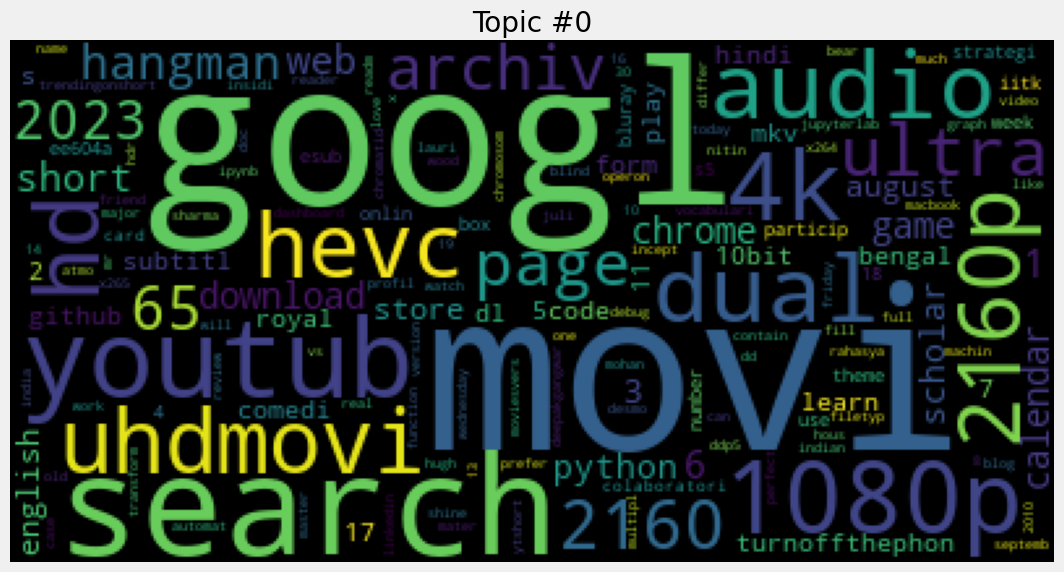

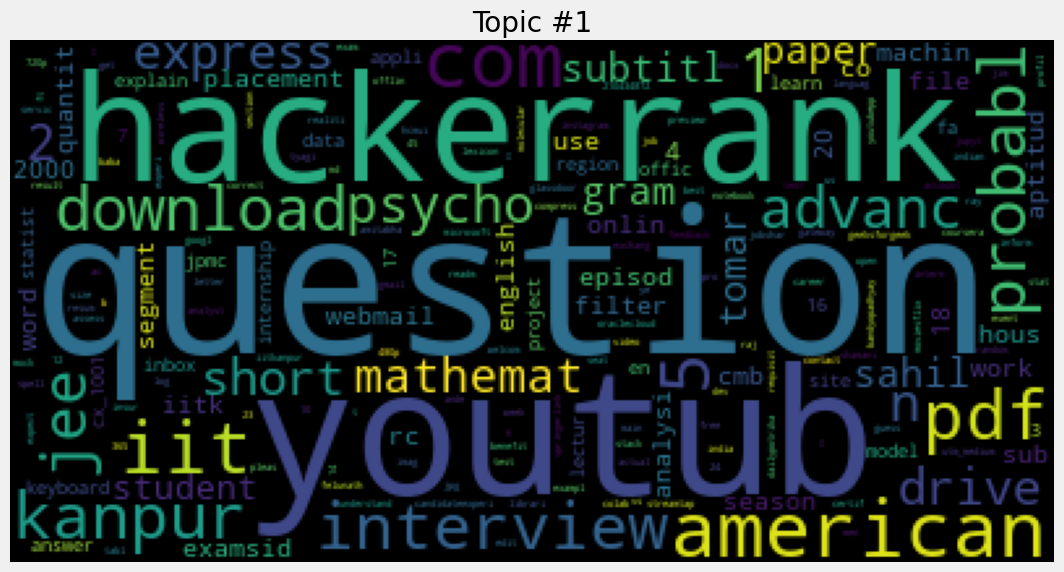

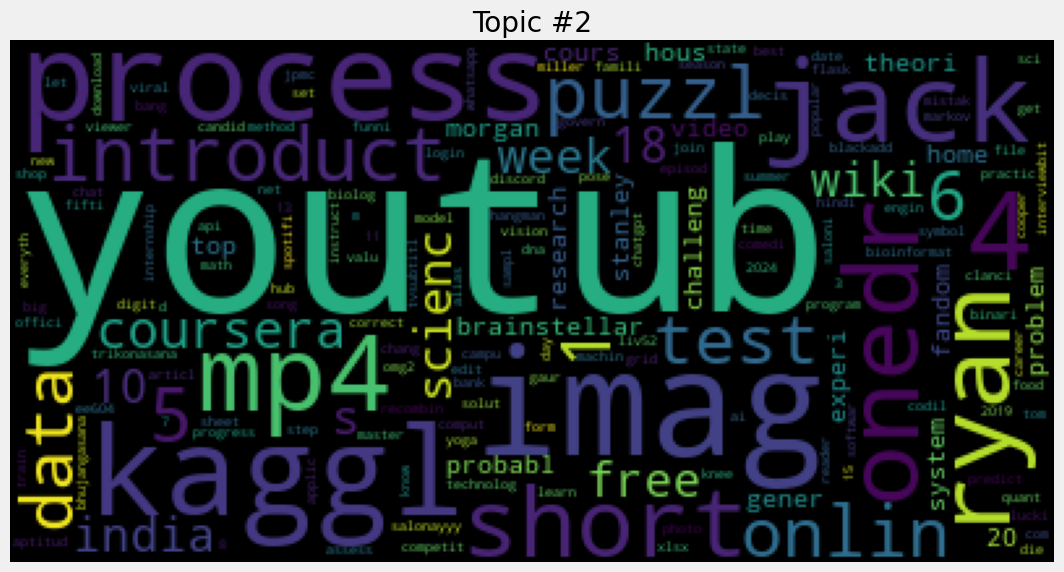

In [716]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming ldamodel is your LDA model object

for t in range(ldamodel.num_topics):
    topic_words = ldamodel.show_topic(t, 200)  # Get topic words and probabilities
    word_freq = {word: prob for word, prob in topic_words}
    
    plt.figure(figsize=(12, 8))
    plt.imshow(WordCloud().generate_from_frequencies(word_freq))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


In [717]:
topic = [0]*len(data)
for idx in range(len(data)):
    test_idx = doc_set.index(data.title[idx])
    probs = ldamodel[dictionary.doc2bow(texts[test_idx])]
    topicProbs = []
    for i in probs:
        topicProbs.append(i[1])
    topic[idx] = np.argmax(np.asarray(topicProbs))

In [771]:
data['Topic']=topic
from collections import Counter
topics=data.groupby([data.index.date,data.index.hour])['Topic'].apply(lambda x: Counter(x).most_common(1)[0][0])
topics=pd.DataFrame(topics)
com=pd.to_datetime(topics.index.get_level_values(0).astype('str') +' '+ topics.index.get_level_values(1).astype('str')+ ':00:00')
new_topics= topics.copy()
new_topics.index = com
new_topics



,Topic
2023-07-21 15:00:00,1
2023-07-21 16:00:00,1
2023-07-21 17:00:00,1
2023-07-21 18:00:00,1
2023-07-21 20:00:00,1
...,...
2023-08-20 17:00:00,2
2023-08-20 19:00:00,2
2023-08-20 20:00:00,2
2023-08-20 22:00:00,0


Predicted topic distribution for the next hour (hour 11):
Topic
0    0.538462
1    0.769231
2    1.000000
Name: 11, dtype: float64


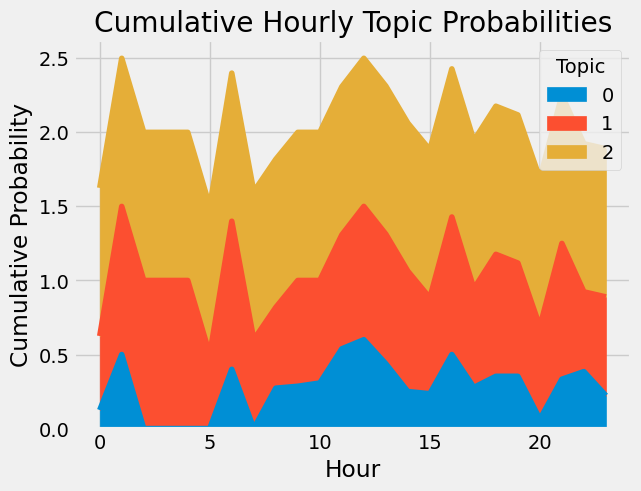

In [773]:
import datetime

# Group data by hour and topic
hourly_data = new_topics.groupby([new_topics.index.hour, 'Topic']).size().unstack(fill_value=0)
hourly_probabilities = hourly_data.div(hourly_data.sum(axis=1), axis=0)
cumulative_hourly_probabilities = hourly_probabilities.cumsum(axis=1)

# Get the current hour and calculate the next hour
current_hour = datetime.datetime.now().hour
next_hour = (current_hour + 1) % 24

# Check if next_hour is present in the index before accessing it
if next_hour in cumulative_hourly_probabilities.index:
    hourly_prediction = cumulative_hourly_probabilities.loc[next_hour]
    print("Predicted topic distribution for the next hour (hour {}):".format(next_hour))
    print(hourly_prediction)
else:
    print("Data for hour {} not available in the index.".format(next_hour))

# Plot cumulative hourly probabilities
cumulative_hourly_probabilities.plot(kind='area', stacked=True)
plt.xlabel('Hour')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Hourly Topic Probabilities')
plt.show()



In [774]:
data.size

23520

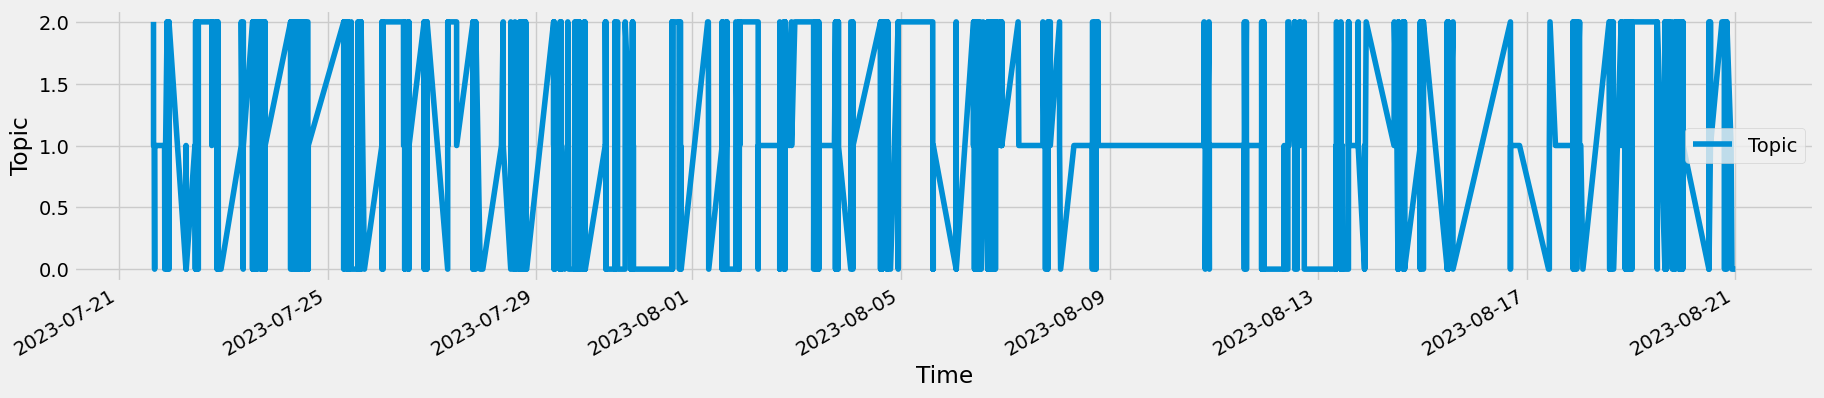

In [775]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is a DataFrame with a datetime-like index and a 'Topic' column

# Sort the data by the datetime-like index
sorted_data = data.sort_index()

# Set the style for the plot
plt.style.use('fivethirtyeight')

# Plot the sorted data
sorted_data.plot(y='Topic', figsize=(20, 4))
plt.xlabel('Time')
plt.ylabel('Topic')
plt.show()


In [776]:
cp_data = data

In [777]:
cp_data

,title,url,Topic
Time,,,
2023-08-21 00:05:56,Export Chrome History - Chrome Web Store,https://chrome.google.com/webstore/detail/expo...,0
2023-08-21 00:05:50,Export Chrome History - Chrome Web Store,https://chrome.google.com/webstore/detail/expo...,0
2023-08-21 00:05:47,history export chrome - Google Search,https://www.google.com/search?q=history+export...,0
2023-08-21 00:05:47,history export chrome - Google Search,https://www.google.com/search?q=history+export...,0
2023-08-20 22:31:33,Wave Motion in Time and Space,https://www.acs.psu.edu/drussell/demos/wave-x-...,0
...,...,...,...
2023-07-21 15:55:05,How to introduce yourself in a technical inter...,https://www.google.com/search?rlz=1C5CHFA_enIN...,1
2023-07-21 15:54:58,How to introduce yourself in a technical inter...,https://www.google.com/search?q=How+to+introdu...,1
2023-07-21 15:54:56,How to introduce yourself in a technical inter...,https://www.google.com/search?q=How+to+introdu...,1


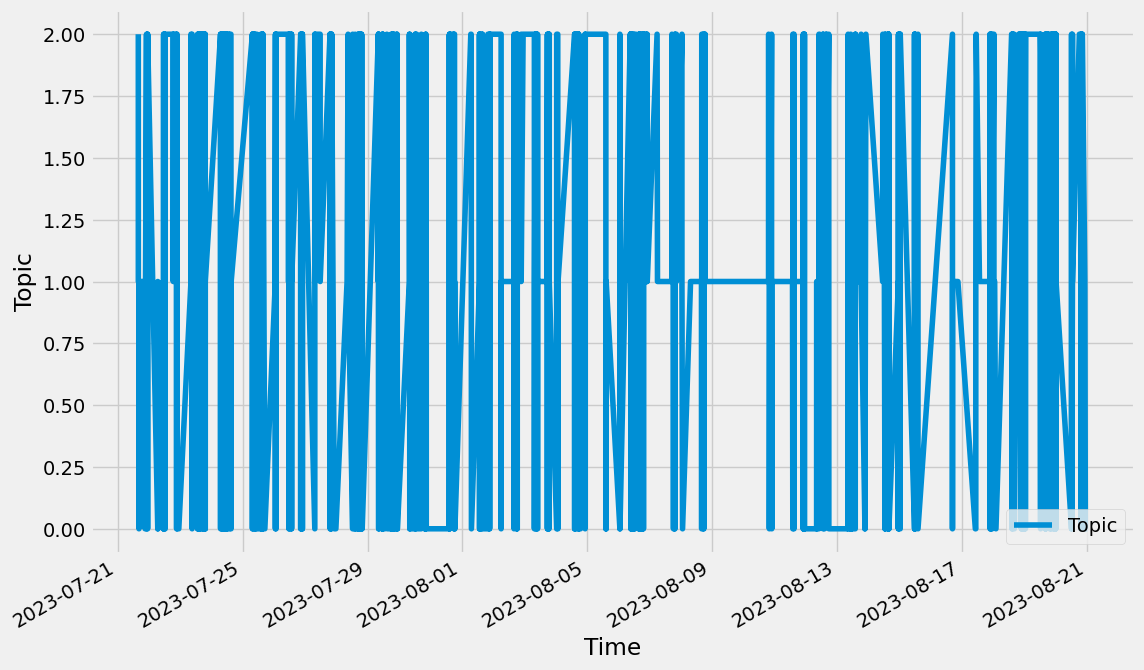

In [778]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cp_data has a datetime-like index and a 'Topic' column

# Sort the data by the datetime-like index
sorted_data = cp_data.sort_index()

# Set the style for the plot
plt.style.use('fivethirtyeight')

# Plot the sorted data
sorted_data.plot(y='Topic', figsize=(12, 8))
plt.xlabel('Time')
plt.ylabel('Topic')
plt.show()


In [779]:
occurrences = []
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day_name in weekdays:
    day_idx=weekdays.index(day_name)
    tlist = cp_data[cp_data.index.weekday == day_idx].Topic.tolist()
    res = np.histogram(tlist, bins=[0, 1, 2, 3])
    occurrences.append(list(res[0]))

In [780]:
t0 = [0]*len(occurrences)
t1 = [0]*len(occurrences)
t2 = [0]*len(occurrences)

for d in range(len(occurrences)):
    t0[d] = occurrences[d][0]
    t1[d] = occurrences[d][1]
    t2[d] = occurrences[d][2]

cumt1 = [sum(x) for x in zip(t0, t1)]

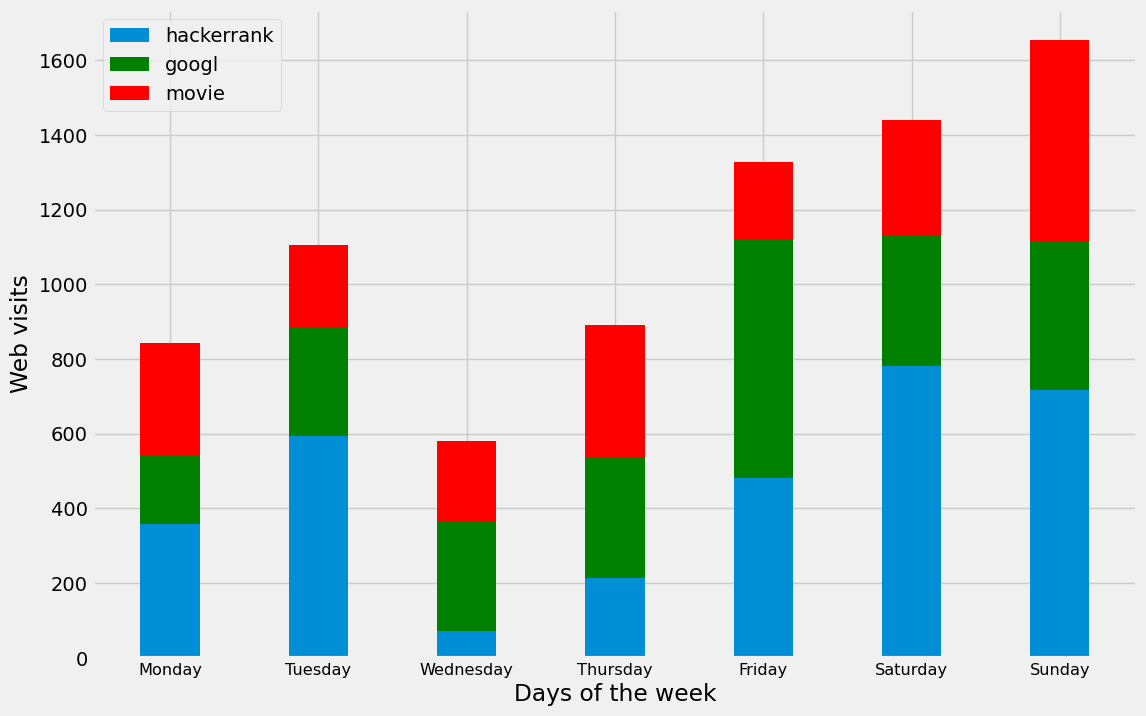

In [781]:
plt.figure(figsize=(12,8))
p0 = plt.bar(range(7), t0, 0.4, label='hackerrank')
p1 = plt.bar(range(7), t1, 0.4,bottom=t0, color='green', label='googl')
p2 = plt.bar(range(7), t2, 0.4, bottom=cumt1, color='red', label='movie')
plt.xticks(range(7), weekdays, size='small')
plt.xlabel('Days of the week')
plt.ylabel('Web visits')
plt.legend()
plt.show()

In [ ]:
# Existing code for topic modeling and occurrences

# Identify Transition Points
threshold = 0.5  # Set a threshold for topic change
transition_points = []
previous_topic = None
for idx in range(len(cp_data)):
    current_topic = cp_data.Topic[idx]
    if previous_topic is not None and abs(current_topic - previous_topic) >= threshold:
        transition_points.append(idx)
    previous_topic = current_topic

# Characterize Location within Topic and Use Dwell Time
dwell_time_threshold = pd.Timedelta(minutes=10)  # Set a threshold for dwell time
for transition_idx in transition_points:
    previous_idx = transition_idx - 1
    current_idx = transition_idx
    previous_topic_probs = ldamodel[dictionary.doc2bow(texts[previous_idx])]
    current_topic_probs = ldamodel[dictionary.doc2bow(texts[current_idx])]
    dwell_time = cp_data.index[current_idx] - cp_data.index[previous_idx]
    
    # Print or store results as needed
    print("Transition at", cp_data.index[current_idx])
    print("Previous Topic Probabilities:", previous_topic_probs)
    print("Current Topic Probabilities:", current_topic_probs)
    print("Dwell Time:", dwell_time)
    print("=" * 50)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... (your existing code to load data and perform topic modeling)

# Initialize topic probability data for all topics
topic_probs_over_time = {topic: [] for topic in range(ldamodel.num_topics)}

# Populate topic probability data
for idx in range(len(cp_data)):
    topic_probs = ldamodel.get_document_topics(corpus[idx])
    for topic, prob in topic_probs:
        topic_probs_over_time[topic].append((cp_data.index[idx], prob))

# Create line graphs for each topic
plt.figure(figsize=(12, 8))
for topic, probs in topic_probs_over_time.items():
    time, probabilities = zip(*probs)
    plt.plot(time, probabilities, label=f"Topic {topic}")

plt.xlabel('Time')
plt.ylabel('Topic Probability')
plt.title('Topic Probabilities Over Time')
plt.legend()
plt.show()

NameError: name 'ldamodel' is not defined